# **CISC3024 Pattern Recognition Final Project**
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC127853

# 0. Project Setup

## 0.1 Packages & Device

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import numpy as np
import cv2
import os
import time

In [3]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


## 0.2 Global Configurations

In [4]:
path_dataset = "./data/SVHN_mat"
norm_mean = [0.4377, 0.4438, 0.4728]
norm_std = [0.1980, 0.2010, 0.1970]

# 1. Data Processing and Augmentation

## 1.1 Download Datasets
Define dataset class, retrieve dataset.

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

In [6]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        data = sio.loadmat(mat_file)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [7]:
transform = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.Rotate(limit=30),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=transform)
test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=transform)
extra_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"extra_32x32.mat"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
extra_loader = DataLoader(Subset(extra_dataset, indices=list(range(30000))), batch_size=64, shuffle=False)

print(f"Train Size:{train_dataset.__len__()}\nTest Size:{test_dataset.__len__()}\nExtra Size:{extra_dataset.__len__()}")

Train Size:73257
Test Size:26032
Extra Size:531131


## 1.2 Peak A Data

In [8]:
import random

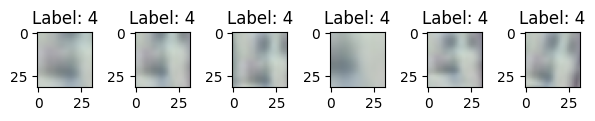

Peaking data from training set of index 55208.
Image Tnesor Size:torch.Size([3, 32, 32])


In [9]:
def unnormalize(img, mean, std):
    """Revert the normalization for visualization."""
    img = img * std + mean
    return np.clip(img, 0, 1)

# Plotting multiple images in a grid
grid_rows, grid_cols = 1, 6

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))

peak_index = random.randint(0, train_dataset.__len__()-1)

for i in range(grid_cols):
    img_tensor, label = train_dataset.__getitem__(peak_index)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = unnormalize(img, norm_mean, norm_std)

    ax = axes[i]  # Get subplot axis
    ax.imshow(img)
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

print(f"Peaking data from training set of index {peak_index}.\nImage Tnesor Size:{train_dataset.__getitem__(peak_index)[0].shape}")

# 2. Neuron Network Structure

## 2.1 Specify Model Structure

In [10]:
class SmallVGG(nn.Module):
    def __init__(self, frame_size=32):
        super(SmallVGG, self).__init__()
        self.frame_size = frame_size
        self. conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(frame_size * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 2.2 Initialize with Hyper Parameters

In [11]:
num_epochs = 30
learning_rate = 0.001
model = SmallVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 2.3 Train and Evaluate

In [12]:
def train_and_evaluate(model,
                      train_loader,
                      test_loader,
                      criterion,
                      optimizer,
                      num_epochs=100):
    # Record Losses to plot
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(images)
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(images)

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss:{train_losses[-1]:.4f}, Test Loss:{test_losses[-1]:.4f}")

    return train_losses, test_losses

In [12]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), f"./models/small_vgg_ne-{num_epochs}_lr-{learning_rate:.0e}.pth")

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 38.78it/s]


Epoch[1/30], Train Loss:269.0844, Test Loss:224.3931


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.24it/s]


Epoch[2/30], Train Loss:183.8657, Test Loss:152.7722


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.05it/s]


Epoch[3/30], Train Loss:148.5520, Test Loss:139.2264


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.96it/s]


Epoch[4/30], Train Loss:136.3398, Test Loss:132.5165


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.10it/s]


Epoch[5/30], Train Loss:129.5036, Test Loss:126.3486


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.84it/s]


Epoch[6/30], Train Loss:125.4178, Test Loss:120.2768


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.90it/s]


Epoch[7/30], Train Loss:121.9030, Test Loss:117.5329


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.03it/s]


Epoch[8/30], Train Loss:119.4886, Test Loss:115.2610


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.18it/s]


Epoch[9/30], Train Loss:117.4120, Test Loss:112.0038


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.63it/s]


Epoch[10/30], Train Loss:114.4023, Test Loss:110.8437


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.93it/s]


Epoch[11/30], Train Loss:114.2462, Test Loss:106.9263


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.33it/s]


Epoch[12/30], Train Loss:113.2152, Test Loss:107.3380


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.98it/s]


Epoch[13/30], Train Loss:111.3432, Test Loss:103.5555


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.84it/s]


Epoch[14/30], Train Loss:110.4658, Test Loss:105.3292


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.02it/s]


Epoch[15/30], Train Loss:109.5433, Test Loss:102.8350


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.97it/s]


Epoch[16/30], Train Loss:109.4585, Test Loss:103.0470


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.69it/s]


Epoch[17/30], Train Loss:107.8355, Test Loss:102.9982


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.78it/s]


Epoch[18/30], Train Loss:107.3608, Test Loss:106.8535


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.94it/s]


Epoch[19/30], Train Loss:107.7781, Test Loss:100.5108


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.58it/s]


Epoch[20/30], Train Loss:106.8044, Test Loss:99.5869


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.35it/s]


Epoch[21/30], Train Loss:106.0726, Test Loss:99.3662


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.34it/s]


Epoch[22/30], Train Loss:105.9276, Test Loss:100.2521


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.73it/s]


Epoch[23/30], Train Loss:104.3199, Test Loss:99.2494


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.52it/s]


Epoch[24/30], Train Loss:104.3040, Test Loss:100.1059


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.01it/s]


Epoch[25/30], Train Loss:104.2286, Test Loss:97.9395


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.19it/s]


Epoch[26/30], Train Loss:103.6763, Test Loss:98.8155


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.03it/s]


Epoch[27/30], Train Loss:104.1006, Test Loss:97.7697


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.23it/s]


Epoch[28/30], Train Loss:103.2498, Test Loss:101.0847


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.77it/s]


Epoch[29/30], Train Loss:103.6581, Test Loss:96.2499


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.21it/s]


Epoch[30/30], Train Loss:102.7017, Test Loss:98.2706


## 2.4 Visualize Result
Multiple functions are defined to evaluate data. Below is a list of them.

#### `get_predictions`
Get a model prediction on 30,000 data on `extra.mat`.
- params:
    - `model_path`: The directory at which the model is stored.
    - `extra_loader`: The `DataLoader` object for loading `extra.mat`.
- returns:
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
    - `true_labels`: A list of ground-truth labels.
    - `pred_labels`: A list of predicted labels.
---

#### `display_cm`
Plots the Confusion Matrix.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_labels`: A list of predicted labels.
- returns: `None`
---

#### `get_metrics`
Get evaluation metrics based on the given prediction results.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_labels`: A list of predicted labels.
- returns:
    - `accuracy`: A single universal accuracy. $acc=\dfrac{\text{\#. of correctly classified data}}{\text{\#. of data}}$
    - `precision`: A class-wise list of classification precisions. $P_i=\dfrac{TP}{TP+TN}$
    - `recall`: A class-wise list of classification recalls. $R_i=\dfrac{TP}{TP+FP}$
    - `f1`: A class-wise list of harmonic mean of precision and recall. $F_1=\dfrac{P+R}{2PR}$
---

#### `display_pr_curve`
Plot the precision-recall curve.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
- returns: `None` 
---

#### `get_roc_auc`
Get the `roc_auc` scores.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
- returns:
    - `roc_auc`: A class-wise list of `roc_auc` scores.
---

#### `display_roc_auc`
Plot the `roc` curve.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
- returns: `None`

In [13]:
from sklearn.metrics import (confusion_matrix, accuracy_score,
                            precision_score, recall_score,
                            f1_score, roc_auc_score,
                            roc_curve, precision_recall_curve,
                            average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### 2.4.0 Predict with Extra Data
First, use the trained model to predict 30,000 image data from `extra.mat`, which is unseen in neither `train.mat` nor `test.mat`. Robustness on `extra` proves the usability of the model.

Results may contain the following:
- Epoch-Loss Curve of model training
- Confusion Matrix
- Accuracy, Precision, Recall and $F_1$ score.

In [14]:
def get_predictions(model_path, extra_loader):
    model_state = torch.load(model_path)
    model = SmallVGG()
    model.load_state_dict(model_state)
    
    model.to(device)
    model.eval() 
    
    pred_scores = []  # Prob. of predictions
    true_labels = []  # Ground Truth
    pred_labels = []  # Label of prediction, i.e., argmax(softmax(pred_scores))
    
    with torch.no_grad():
        for images, labels in tqdm(extra_loader):
            images, labels = images.to(device), labels.to(device)
        
            outputs = model(images)
    
            pred_scores_batch = nn.functional.softmax(outputs, dim=-1)
    
            pred_scores.extend(pred_scores_batch.cpu().tolist())
            pred_labels.extend(outputs.argmax(dim=1).tolist())
            true_labels.extend(labels.cpu().tolist())
            
    return pred_scores, true_labels, pred_labels

In [15]:
pred_scores, true_labels_cpu, pred_labels_cpu = get_predictions("./models/small_vgg_ne-30_lr-1e-03.pth", extra_loader)
print("First 100 true labels:")
[print(num, end=" ") for num in true_labels_cpu[:100]]
print("...\n")

print("First 100 predictions:")
[print(num, end=" ") for num in pred_labels_cpu[:100]]
print("...\n")

print("Prediction Probabilities:")
[print(arr) for arr in pred_scores[:5]]
print("...")

D:\Temps\temp\ipykernel_29292\3475512123.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)
100%|██████████████████████████████████████

First 100 true labels:
4 7 8 7 1 1 7 4 3 0 2 8 8 3 1 1 7 0 8 1 5 6 4 4 4 6 3 4 4 3 0 1 7 6 0 1 1 0 5 7 5 1 8 5 5 2 9 6 1 5 2 3 5 3 6 9 2 3 4 1 7 7 3 1 2 2 0 1 1 3 1 5 1 1 9 9 4 8 0 5 1 3 8 2 9 5 6 0 7 8 3 0 6 4 0 3 1 1 0 0 ...

First 100 predictions:
4 1 8 7 7 1 7 4 3 0 2 8 0 3 1 1 7 0 8 1 6 6 4 4 4 6 3 4 4 3 0 7 7 6 0 1 1 0 2 7 5 1 4 5 3 2 9 6 1 4 6 3 5 3 6 7 2 3 4 1 7 7 3 1 2 2 2 1 1 3 1 5 1 1 9 9 4 3 0 5 1 3 9 2 0 6 6 0 7 8 3 1 6 4 0 7 1 1 1 8 ...

Prediction Probabilities:
[7.564401312265545e-05, 0.001672823098488152, 0.0010354656260460615, 0.0033441961277276278, 0.9874839186668396, 0.0007910538115538657, 0.0009172347490675747, 0.0022566476836800575, 0.0016073824372142553, 0.0008156428812071681]
[0.00012675659672822803, 0.9644230008125305, 0.0007670297054573894, 0.00124127056915313, 0.002548323478549719, 6.851315993117169e-05, 0.0006123455823399127, 0.02928384393453598, 0.0005660591996274889, 0.0003628291597124189]
[2.653884045855648e-08, 1.8440124449625728e-06, 1.6757052208049572e

### 2.4.1 Epoch-Loss Curves

In [15]:
def display_el_curve(train_losses, test_losses):
    plt.figure(figsize=(3,3))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss Curves")
    plt.legend()
    plt.show()

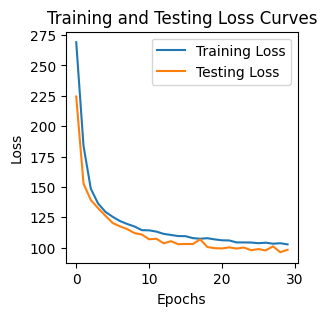

In [17]:
display_el_curve(train_losses, test_losses)

### 2.4.2 Confusion Matrix

In [16]:
def display_cm(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0,10))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

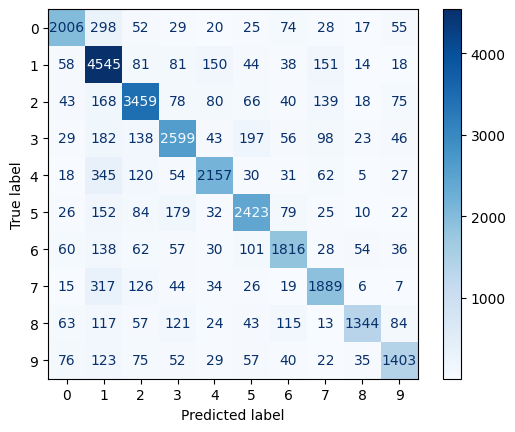

In [19]:
display_cm(true_labels_cpu, pred_labels_cpu)

### 2.4.3 Accuracy, Precision, Recall and $F_1$ Score

In [20]:
true_labels_bin = label_binarize(true_labels_cpu, classes=range(0,10))
true_labels_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [21]:
pred_labels_bin = label_binarize(pred_labels_cpu, classes=range(0,10))
pred_labels_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [16]:
def get_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels_cpu, pred_labels_cpu)
    precision = precision_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))
    recall = recall_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))
    f1 = f1_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))

    return accuracy, precision, recall, f1

In [23]:
accuracy, precision, recall, f1 = get_metrics(true_labels_cpu, pred_labels_cpu)
print(f"Accuracy:{accuracy:.2f}")
for i in range(10):
    print(f"Class {i}: Prec:{precision[i]:.2f}, Recall:{recall[i]:.2f}, F_1 Score:{f1[i]:.2f}")

Accuracy:0.79
Class 0: Prec:0.84, Recall:0.77, F_1 Score:0.80
Class 1: Prec:0.71, Recall:0.88, F_1 Score:0.79
Class 2: Prec:0.81, Recall:0.83, F_1 Score:0.82
Class 3: Prec:0.79, Recall:0.76, F_1 Score:0.78
Class 4: Prec:0.83, Recall:0.76, F_1 Score:0.79
Class 5: Prec:0.80, Recall:0.80, F_1 Score:0.80
Class 6: Prec:0.79, Recall:0.76, F_1 Score:0.77
Class 7: Prec:0.77, Recall:0.76, F_1 Score:0.77
Class 8: Prec:0.88, Recall:0.68, F_1 Score:0.77
Class 9: Prec:0.79, Recall:0.73, F_1 Score:0.76


In [17]:
def display_pr_curve(true_labels_bin, pred_scores):
    for i in range(0, 10):
        precision_i, recall_i, _ = precision_recall_curve(true_labels_bin[:, i], np.array(pred_scores)[:, i])
        average_precision = average_precision_score(true_labels_bin[:, i], np.array(pred_scores)[:, i])
        plt.step(recall_i, precision_i, where="post", label=f"Class {i} AP={average_precision:.2f}")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

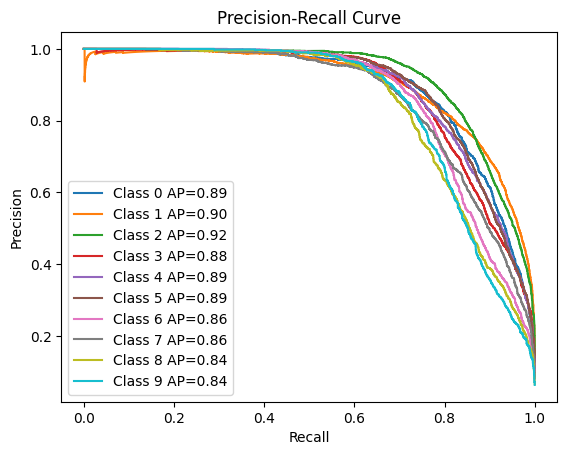

In [25]:
display_pr_curve(true_labels_bin, pred_scores)

### 2.4.4 ROC curve and ROC AUC
To compute ROC (Receiver Operating Characteristic), we need to first specify positive class using `label_binarize`.

In [20]:
# Compute ROC AUC for each class
def get_roc_auc(true_labels_bin, pred_labels_bin):
    roc_auc = dict()
    for i in range(0, 10):
        roc_auc[i] = roc_auc_score(true_labels_bin[:,i], np.array(pred_scores)[:, i])
    return roc_auc

In [27]:
roc_auc = get_roc_auc(true_labels_bin, pred_labels_bin)
for i, val in roc_auc.items():
    print(f"Class {i}: ROC AUC = {val:.2f}")

Class 0: ROC AUC = 0.98
Class 1: ROC AUC = 0.97
Class 2: ROC AUC = 0.98
Class 3: ROC AUC = 0.97
Class 4: ROC AUC = 0.98
Class 5: ROC AUC = 0.98
Class 6: ROC AUC = 0.97
Class 7: ROC AUC = 0.97
Class 8: ROC AUC = 0.97
Class 9: ROC AUC = 0.97


In [19]:
# Plot ROC AUC Curves
def display_roc_auc(true_labels_bin, pred_scores):
    for i in range(0, 10):
        fpr, tpr, _ = roc_curve(true_labels_bin[:,i], np.array(pred_scores)[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}, AUC={roc_auc[i]:.2f}")
    
    plt.plot([0, 1], [0, 1], "k--") # Diagnal Line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.yscale("logit")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

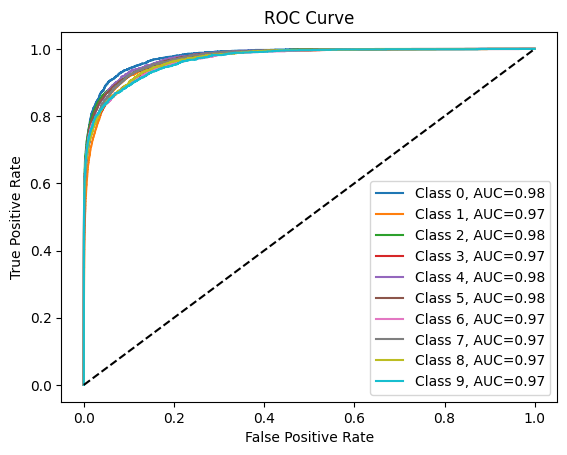

In [29]:
display_roc_auc(true_labels_bin, pred_scores)

# 3. Impact of Multiple Hyper-Parameters on Model Performance 

In [23]:
import itertools

Control candidates for different variables

In [42]:
candidate_epoch_num = [20, 40, 60, 80]
candidate_lr = [1e-3, 1e-4, 1e-5, 1e-6]
# candidate_epoch_num = [20, 40]
# candidate_lr = [1e-3, 1e-4]

From the controlled variables, generate all the possible experiment set.

In [43]:
combinations = list(itertools.product(candidate_epoch_num, candidate_lr))
for combo in combinations:
    print(f"[{combo[0]}, {combo[1]:.0e}]", end=" ")

[20, 1e-03] [20, 1e-04] [20, 1e-05] [20, 1e-06] [40, 1e-03] [40, 1e-04] [40, 1e-05] [40, 1e-06] [60, 1e-03] [60, 1e-04] [60, 1e-05] [60, 1e-06] [80, 1e-03] [80, 1e-04] [80, 1e-05] [80, 1e-06] 

In [44]:
def run_experiment(candidate_epoch_num, candidate_lr):
    combinations = list(itertools.product(candidate_epoch_num, candidate_lr))
    experiments = [] # Experiment Instances
    
    for combo in combinations:
        print(f"Performing Experiment: epoch_num={combo[0]}, lr={combo[1]}")
        exp_model = SmallVGG().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(exp_model.parameters(), lr=combo[1])
        num_epochs = combo[0]
    
        train_losses, test_losses = train_and_evaluate(exp_model, train_loader, test_loader, criterion, optimizer, num_epochs)

        # One experiment instance
        experiments.append({
            "num_epoch": combo[0],
            "lr": combo[1],
            "train_losses": train_losses,
            "test_losses": test_losses,
            "model_state_dict": exp_model.state_dict()
        })
        
        # Prevent CUDA Mem Leak
        del exp_model, criterion, optimizer
        torch.cuda.empty_cache()
        
    return experiments

In [45]:
experiments = run_experiment(candidate_epoch_num, candidate_lr)
time_str = str(time.time()).replace(".","")
torch.save(experiments, f"./models/experiments_{time_str}.pth")

Performing Experiment: epoch_num=20, lr=0.001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.61it/s]


Epoch[1/20], Train Loss:273.6250, Test Loss:226.2518


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.61it/s]


Epoch[2/20], Train Loss:192.3438, Test Loss:165.3802


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.26it/s]


Epoch[3/20], Train Loss:158.9808, Test Loss:146.8151


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.58it/s]


Epoch[4/20], Train Loss:144.1323, Test Loss:133.9099


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.24it/s]


Epoch[5/20], Train Loss:135.7931, Test Loss:130.3998


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.60it/s]


Epoch[6/20], Train Loss:129.6459, Test Loss:126.2093


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.39it/s]


Epoch[7/20], Train Loss:126.2750, Test Loss:119.4754


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.14it/s]


Epoch[8/20], Train Loss:122.8730, Test Loss:117.3750


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.43it/s]


Epoch[9/20], Train Loss:120.9373, Test Loss:117.7390


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.53it/s]


Epoch[10/20], Train Loss:119.1836, Test Loss:112.1904


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.45it/s]


Epoch[11/20], Train Loss:116.5669, Test Loss:112.7011


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.93it/s]


Epoch[12/20], Train Loss:114.7737, Test Loss:111.9802


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.17it/s]


Epoch[13/20], Train Loss:114.1235, Test Loss:111.2841


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 35.96it/s]


Epoch[14/20], Train Loss:112.9559, Test Loss:114.3767


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.53it/s]


Epoch[15/20], Train Loss:111.0698, Test Loss:106.3295


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.72it/s]


Epoch[16/20], Train Loss:112.0243, Test Loss:110.1766


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.91it/s]


Epoch[17/20], Train Loss:109.7080, Test Loss:107.9069


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.30it/s]


Epoch[18/20], Train Loss:108.5583, Test Loss:105.9967


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.30it/s]


Epoch[19/20], Train Loss:109.5603, Test Loss:103.4721


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.84it/s]


Epoch[20/20], Train Loss:108.3114, Test Loss:105.9967
Performing Experiment: epoch_num=20, lr=0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.12it/s]


Epoch[1/20], Train Loss:286.3824, Test Loss:282.5474


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.02it/s]


Epoch[2/20], Train Loss:277.8285, Test Loss:261.4198


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.92it/s]


Epoch[3/20], Train Loss:247.3757, Test Loss:232.7131


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.88it/s]


Epoch[4/20], Train Loss:229.2325, Test Loss:218.5004


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.60it/s]


Epoch[5/20], Train Loss:216.0349, Test Loss:208.2404


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.75it/s]


Epoch[6/20], Train Loss:205.9314, Test Loss:199.8663


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.76it/s]


Epoch[7/20], Train Loss:196.4219, Test Loss:189.1829


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.33it/s]


Epoch[8/20], Train Loss:190.0487, Test Loss:181.5063


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.73it/s]


Epoch[9/20], Train Loss:183.7670, Test Loss:181.0961


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.63it/s]


Epoch[10/20], Train Loss:179.1436, Test Loss:171.9339


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.32it/s]


Epoch[11/20], Train Loss:175.6870, Test Loss:169.1723


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.66it/s]


Epoch[12/20], Train Loss:171.8809, Test Loss:165.4287


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.74it/s]


Epoch[13/20], Train Loss:168.3930, Test Loss:164.0902


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.57it/s]


Epoch[14/20], Train Loss:165.6571, Test Loss:161.6520


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.82it/s]


Epoch[15/20], Train Loss:163.5155, Test Loss:156.4228


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 35.94it/s]


Epoch[16/20], Train Loss:160.6063, Test Loss:153.5970


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.25it/s]


Epoch[17/20], Train Loss:157.8511, Test Loss:153.4596


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.77it/s]


Epoch[18/20], Train Loss:156.5984, Test Loss:148.7951


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.98it/s]


Epoch[19/20], Train Loss:152.8333, Test Loss:147.1627


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.40it/s]


Epoch[20/20], Train Loss:151.1984, Test Loss:146.9617
Performing Experiment: epoch_num=20, lr=1e-05


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.56it/s]


Epoch[1/20], Train Loss:290.2158, Test Loss:284.0060


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.66it/s]


Epoch[2/20], Train Loss:286.0251, Test Loss:283.6935


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.18it/s]


Epoch[3/20], Train Loss:285.9170, Test Loss:283.6253


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.19it/s]


Epoch[4/20], Train Loss:285.8377, Test Loss:283.4673


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.47it/s]


Epoch[5/20], Train Loss:285.7950, Test Loss:283.5199


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.75it/s]


Epoch[6/20], Train Loss:285.6924, Test Loss:283.3490


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.17it/s]


Epoch[7/20], Train Loss:285.4898, Test Loss:282.9781


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.25it/s]


Epoch[8/20], Train Loss:285.0739, Test Loss:282.2394


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.59it/s]


Epoch[9/20], Train Loss:284.0615, Test Loss:280.2230


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.33it/s]


Epoch[10/20], Train Loss:281.5654, Test Loss:276.3494


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.42it/s]


Epoch[11/20], Train Loss:276.9703, Test Loss:271.2993


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.06it/s]


Epoch[12/20], Train Loss:271.3448, Test Loss:265.7829


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.49it/s]


Epoch[13/20], Train Loss:266.6732, Test Loss:263.1316


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.45it/s]


Epoch[14/20], Train Loss:263.4424, Test Loss:259.5436


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.00it/s]


Epoch[15/20], Train Loss:260.9711, Test Loss:258.2017


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.21it/s]


Epoch[16/20], Train Loss:259.3022, Test Loss:257.2764


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.99it/s]


Epoch[17/20], Train Loss:257.5728, Test Loss:256.4187


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.72it/s]


Epoch[18/20], Train Loss:256.3358, Test Loss:254.4685


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.39it/s]


Epoch[19/20], Train Loss:255.3257, Test Loss:254.6504


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.82it/s]


Epoch[20/20], Train Loss:254.0659, Test Loss:252.7717
Performing Experiment: epoch_num=20, lr=1e-06


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.30it/s]


Epoch[1/20], Train Loss:295.6317, Test Loss:295.0451


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.28it/s]


Epoch[2/20], Train Loss:295.1768, Test Loss:294.5195


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.45it/s]


Epoch[3/20], Train Loss:294.6344, Test Loss:293.8320


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.40it/s]


Epoch[4/20], Train Loss:293.8402, Test Loss:292.7308


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 37.26it/s]


Epoch[5/20], Train Loss:292.4189, Test Loss:290.4903


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.90it/s]


Epoch[6/20], Train Loss:289.9625, Test Loss:287.3102


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 38.37it/s]


Epoch[7/20], Train Loss:287.6297, Test Loss:285.1984


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.30it/s]


Epoch[8/20], Train Loss:286.6804, Test Loss:284.5516


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.38it/s]


Epoch[9/20], Train Loss:286.3947, Test Loss:284.2665


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.45it/s]


Epoch[10/20], Train Loss:286.2675, Test Loss:284.1292


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.28it/s]


Epoch[11/20], Train Loss:286.2180, Test Loss:284.0686


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.41it/s]


Epoch[12/20], Train Loss:286.1664, Test Loss:284.0337


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.34it/s]


Epoch[13/20], Train Loss:286.1440, Test Loss:283.9513


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.62it/s]


Epoch[14/20], Train Loss:286.1358, Test Loss:283.9522


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.24it/s]


Epoch[15/20], Train Loss:286.1174, Test Loss:283.9397


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.29it/s]


Epoch[16/20], Train Loss:286.1081, Test Loss:283.8998


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.53it/s]


Epoch[17/20], Train Loss:286.1045, Test Loss:283.9459


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 37.80it/s]


Epoch[18/20], Train Loss:286.0845, Test Loss:283.8653


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.69it/s]


Epoch[19/20], Train Loss:286.0876, Test Loss:283.8984


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.78it/s]


Epoch[20/20], Train Loss:286.0620, Test Loss:283.8739
Performing Experiment: epoch_num=40, lr=0.001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.06it/s]


Epoch[1/40], Train Loss:252.5546, Test Loss:198.3760


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.61it/s]


Epoch[2/40], Train Loss:176.1080, Test Loss:156.2775


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.80it/s]


Epoch[3/40], Train Loss:149.5769, Test Loss:138.1545


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.90it/s]


Epoch[4/40], Train Loss:137.5053, Test Loss:132.4482


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.51it/s]


Epoch[5/40], Train Loss:131.3698, Test Loss:126.0467


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.67it/s]


Epoch[6/40], Train Loss:126.8446, Test Loss:117.8059


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 39.98it/s]


Epoch[7/40], Train Loss:121.6506, Test Loss:117.4404


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 40.86it/s]


Epoch[8/40], Train Loss:119.9389, Test Loss:112.2045


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 40.04it/s]


Epoch[9/40], Train Loss:118.0162, Test Loss:113.9959


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 40.56it/s]


Epoch[10/40], Train Loss:115.2518, Test Loss:110.4475


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 37.24it/s]


Epoch[11/40], Train Loss:114.9973, Test Loss:109.8806


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.01it/s]


Epoch[12/40], Train Loss:112.9299, Test Loss:105.4914


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.99it/s]


Epoch[13/40], Train Loss:112.1285, Test Loss:108.4001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.55it/s]


Epoch[14/40], Train Loss:111.8850, Test Loss:105.5100


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.85it/s]


Epoch[15/40], Train Loss:110.6797, Test Loss:107.2092


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.40it/s]


Epoch[16/40], Train Loss:109.7235, Test Loss:107.9702


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.58it/s]


Epoch[17/40], Train Loss:109.5188, Test Loss:103.6870


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.18it/s]


Epoch[18/40], Train Loss:108.2240, Test Loss:104.9807


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.85it/s]


Epoch[19/40], Train Loss:108.1700, Test Loss:103.0870


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.51it/s]


Epoch[20/40], Train Loss:107.6236, Test Loss:104.1072


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.91it/s]


Epoch[21/40], Train Loss:106.7039, Test Loss:103.1942


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.77it/s]


Epoch[22/40], Train Loss:106.2380, Test Loss:98.7930


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.24it/s]


Epoch[23/40], Train Loss:104.8741, Test Loss:103.6761


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.42it/s]


Epoch[24/40], Train Loss:105.2382, Test Loss:101.0090


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.91it/s]


Epoch[25/40], Train Loss:106.1663, Test Loss:99.8675


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.83it/s]


Epoch[26/40], Train Loss:104.2536, Test Loss:100.7559


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.95it/s]


Epoch[27/40], Train Loss:103.6044, Test Loss:100.3231


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.33it/s]


Epoch[28/40], Train Loss:104.3160, Test Loss:98.0720


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.14it/s]


Epoch[29/40], Train Loss:103.6296, Test Loss:97.5014


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.99it/s]


Epoch[30/40], Train Loss:103.0167, Test Loss:98.2294


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.34it/s]


Epoch[31/40], Train Loss:102.3464, Test Loss:98.1610


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.34it/s]


Epoch[32/40], Train Loss:103.2416, Test Loss:95.4067


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.12it/s]


Epoch[33/40], Train Loss:102.9440, Test Loss:95.7281


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.08it/s]


Epoch[34/40], Train Loss:102.4315, Test Loss:97.5378


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.15it/s]


Epoch[35/40], Train Loss:102.5919, Test Loss:98.1286


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.45it/s]


Epoch[36/40], Train Loss:102.8453, Test Loss:96.1490


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.04it/s]


Epoch[37/40], Train Loss:102.1551, Test Loss:97.1761


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.74it/s]


Epoch[38/40], Train Loss:101.6684, Test Loss:96.0527


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.76it/s]


Epoch[39/40], Train Loss:102.4429, Test Loss:97.5615


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.44it/s]


Epoch[40/40], Train Loss:100.7082, Test Loss:97.2595
Performing Experiment: epoch_num=40, lr=0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.29it/s]


Epoch[1/40], Train Loss:286.4365, Test Loss:283.3193


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.73it/s]


Epoch[2/40], Train Loss:276.2484, Test Loss:259.4074


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.41it/s]


Epoch[3/40], Train Loss:250.3338, Test Loss:243.5947


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.72it/s]


Epoch[4/40], Train Loss:235.6773, Test Loss:225.8585


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.89it/s]


Epoch[5/40], Train Loss:222.8683, Test Loss:219.1508


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.06it/s]


Epoch[6/40], Train Loss:213.6142, Test Loss:209.4114


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.10it/s]


Epoch[7/40], Train Loss:207.3052, Test Loss:200.4252


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 35.91it/s]


Epoch[8/40], Train Loss:201.5742, Test Loss:194.0860


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 38.09it/s]


Epoch[9/40], Train Loss:193.8038, Test Loss:187.6225


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 37.33it/s]


Epoch[10/40], Train Loss:187.8839, Test Loss:183.8923


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 38.48it/s]


Epoch[11/40], Train Loss:182.7916, Test Loss:175.6935


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 37.02it/s]


Epoch[12/40], Train Loss:177.5759, Test Loss:171.8337


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.65it/s]


Epoch[13/40], Train Loss:173.9070, Test Loss:167.4274


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.66it/s]


Epoch[14/40], Train Loss:170.8607, Test Loss:164.6920


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.00it/s]


Epoch[15/40], Train Loss:166.8828, Test Loss:160.3560


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 38.12it/s]


Epoch[16/40], Train Loss:163.6345, Test Loss:157.9022


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.01it/s]


Epoch[17/40], Train Loss:161.3861, Test Loss:155.4753


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:15<00:00, 36.99it/s]


Epoch[18/40], Train Loss:158.7531, Test Loss:154.7545


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.28it/s]


Epoch[19/40], Train Loss:156.2212, Test Loss:152.9082


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.73it/s]


Epoch[20/40], Train Loss:153.3404, Test Loss:149.8849


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.84it/s]


Epoch[21/40], Train Loss:153.0120, Test Loss:147.6294


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.08it/s]


Epoch[22/40], Train Loss:150.2570, Test Loss:144.7271


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.18it/s]


Epoch[23/40], Train Loss:147.8549, Test Loss:145.0822


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.27it/s]


Epoch[24/40], Train Loss:145.9972, Test Loss:142.5783


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.35it/s]


Epoch[25/40], Train Loss:144.6299, Test Loss:139.4967


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.72it/s]


Epoch[26/40], Train Loss:143.4625, Test Loss:136.7219


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.34it/s]


Epoch[27/40], Train Loss:141.9160, Test Loss:137.0666


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.02it/s]


Epoch[28/40], Train Loss:141.0530, Test Loss:135.1106


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.68it/s]


Epoch[29/40], Train Loss:139.5733, Test Loss:133.7263


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.85it/s]


Epoch[30/40], Train Loss:138.3087, Test Loss:132.2758


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.74it/s]


Epoch[31/40], Train Loss:136.7301, Test Loss:131.2139


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.81it/s]


Epoch[32/40], Train Loss:135.3149, Test Loss:133.6783


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.25it/s]


Epoch[33/40], Train Loss:134.6403, Test Loss:129.7076


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[34/40], Train Loss:133.5803, Test Loss:128.8422


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.02it/s]


Epoch[35/40], Train Loss:132.4256, Test Loss:127.5469


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[36/40], Train Loss:131.2303, Test Loss:129.9772


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.27it/s]


Epoch[37/40], Train Loss:130.1258, Test Loss:126.9177


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.38it/s]


Epoch[38/40], Train Loss:130.0177, Test Loss:125.8382


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.37it/s]


Epoch[39/40], Train Loss:129.3370, Test Loss:123.4188


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[40/40], Train Loss:127.8257, Test Loss:124.4013
Performing Experiment: epoch_num=40, lr=1e-05


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[1/40], Train Loss:289.9424, Test Loss:283.8720


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[2/40], Train Loss:286.1301, Test Loss:283.6979


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.08it/s]


Epoch[3/40], Train Loss:285.9707, Test Loss:283.6336


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.24it/s]


Epoch[4/40], Train Loss:285.8522, Test Loss:283.5098


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.15it/s]


Epoch[5/40], Train Loss:285.7708, Test Loss:283.5449


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.16it/s]


Epoch[6/40], Train Loss:285.6705, Test Loss:283.3643


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.83it/s]


Epoch[7/40], Train Loss:285.5570, Test Loss:283.1740


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.14it/s]


Epoch[8/40], Train Loss:285.3613, Test Loss:282.7917


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.55it/s]


Epoch[9/40], Train Loss:285.0162, Test Loss:282.5598


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.41it/s]


Epoch[10/40], Train Loss:284.4857, Test Loss:281.9348


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.11it/s]


Epoch[11/40], Train Loss:283.4750, Test Loss:280.3187


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[12/40], Train Loss:281.8663, Test Loss:277.9629


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.12it/s]


Epoch[13/40], Train Loss:279.2368, Test Loss:274.5834


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.23it/s]


Epoch[14/40], Train Loss:275.5871, Test Loss:270.7961


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.18it/s]


Epoch[15/40], Train Loss:271.8243, Test Loss:266.3494


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.38it/s]


Epoch[16/40], Train Loss:268.5173, Test Loss:264.4293


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.66it/s]


Epoch[17/40], Train Loss:265.9794, Test Loss:262.5643


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.44it/s]


Epoch[18/40], Train Loss:264.1683, Test Loss:261.2106


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.95it/s]


Epoch[19/40], Train Loss:262.5633, Test Loss:260.0413


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.11it/s]


Epoch[20/40], Train Loss:261.2260, Test Loss:258.6385


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.89it/s]


Epoch[21/40], Train Loss:259.9555, Test Loss:257.4064


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.76it/s]


Epoch[22/40], Train Loss:258.4210, Test Loss:255.9947


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.24it/s]


Epoch[23/40], Train Loss:257.6317, Test Loss:254.6396


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.51it/s]


Epoch[24/40], Train Loss:255.8194, Test Loss:254.6260


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[25/40], Train Loss:254.7669, Test Loss:252.9773


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.86it/s]


Epoch[26/40], Train Loss:253.7477, Test Loss:252.0643


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.24it/s]


Epoch[27/40], Train Loss:253.3600, Test Loss:251.0859


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[28/40], Train Loss:251.4466, Test Loss:250.2249


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.78it/s]


Epoch[29/40], Train Loss:250.7752, Test Loss:247.9011


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.77it/s]


Epoch[30/40], Train Loss:250.0992, Test Loss:249.3162


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[31/40], Train Loss:248.6201, Test Loss:246.7114


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.21it/s]


Epoch[32/40], Train Loss:247.1963, Test Loss:245.5311


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.61it/s]


Epoch[33/40], Train Loss:245.8526, Test Loss:244.0514


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.63it/s]


Epoch[34/40], Train Loss:244.6200, Test Loss:242.6640


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.13it/s]


Epoch[35/40], Train Loss:243.8005, Test Loss:243.5267


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[36/40], Train Loss:243.3290, Test Loss:241.8712


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.17it/s]


Epoch[37/40], Train Loss:241.4309, Test Loss:239.2189


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.25it/s]


Epoch[38/40], Train Loss:240.5895, Test Loss:237.7867


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.48it/s]


Epoch[39/40], Train Loss:239.7811, Test Loss:238.6575


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[40/40], Train Loss:238.1266, Test Loss:236.9292
Performing Experiment: epoch_num=40, lr=1e-06


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.13it/s]


Epoch[1/40], Train Loss:294.1970, Test Loss:293.3686


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.51it/s]


Epoch[2/40], Train Loss:293.6697, Test Loss:292.6483


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.98it/s]


Epoch[3/40], Train Loss:292.8289, Test Loss:291.3830


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.69it/s]


Epoch[4/40], Train Loss:291.2424, Test Loss:288.8480


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.13it/s]


Epoch[5/40], Train Loss:288.6997, Test Loss:285.7693


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.23it/s]


Epoch[6/40], Train Loss:286.8086, Test Loss:284.4054


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.41it/s]


Epoch[7/40], Train Loss:286.2995, Test Loss:284.1282


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.60it/s]


Epoch[8/40], Train Loss:286.1978, Test Loss:284.0558


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.47it/s]


Epoch[9/40], Train Loss:286.1487, Test Loss:284.0121


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.89it/s]


Epoch[10/40], Train Loss:286.1266, Test Loss:283.9756


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[11/40], Train Loss:286.0823, Test Loss:283.9181


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[12/40], Train Loss:286.0681, Test Loss:283.9073


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.10it/s]


Epoch[13/40], Train Loss:286.0454, Test Loss:283.9018


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.38it/s]


Epoch[14/40], Train Loss:286.0397, Test Loss:283.8455


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.60it/s]


Epoch[15/40], Train Loss:286.0335, Test Loss:283.8679


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.15it/s]


Epoch[16/40], Train Loss:286.0137, Test Loss:283.8637


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.13it/s]


Epoch[17/40], Train Loss:286.0131, Test Loss:283.8414


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.08it/s]


Epoch[18/40], Train Loss:285.9974, Test Loss:283.7944


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.86it/s]


Epoch[19/40], Train Loss:285.9874, Test Loss:283.8000


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.37it/s]


Epoch[20/40], Train Loss:285.9849, Test Loss:283.8054


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.12it/s]


Epoch[21/40], Train Loss:285.9937, Test Loss:283.7820


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.63it/s]


Epoch[22/40], Train Loss:285.9757, Test Loss:283.7979


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.26it/s]


Epoch[23/40], Train Loss:285.9643, Test Loss:283.7493


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.85it/s]


Epoch[24/40], Train Loss:285.9544, Test Loss:283.7730


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[25/40], Train Loss:285.9523, Test Loss:283.7589


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[26/40], Train Loss:285.9429, Test Loss:283.7508


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.41it/s]


Epoch[27/40], Train Loss:285.9523, Test Loss:283.7146


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.57it/s]


Epoch[28/40], Train Loss:285.9319, Test Loss:283.7250


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.60it/s]


Epoch[29/40], Train Loss:285.9263, Test Loss:283.7215


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.27it/s]


Epoch[30/40], Train Loss:285.9174, Test Loss:283.7334


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[31/40], Train Loss:285.9163, Test Loss:283.6971


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.29it/s]


Epoch[32/40], Train Loss:285.9020, Test Loss:283.6989


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.25it/s]


Epoch[33/40], Train Loss:285.9120, Test Loss:283.7106


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[34/40], Train Loss:285.8898, Test Loss:283.6811


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[35/40], Train Loss:285.8885, Test Loss:283.6662


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.25it/s]


Epoch[36/40], Train Loss:285.8890, Test Loss:283.7031


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.98it/s]


Epoch[37/40], Train Loss:285.8862, Test Loss:283.6527


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.61it/s]


Epoch[38/40], Train Loss:285.8697, Test Loss:283.6671


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.35it/s]


Epoch[39/40], Train Loss:285.8675, Test Loss:283.6427


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[40/40], Train Loss:285.8620, Test Loss:283.6609
Performing Experiment: epoch_num=60, lr=0.001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.28it/s]


Epoch[1/60], Train Loss:279.5896, Test Loss:237.0638


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[2/60], Train Loss:197.1944, Test Loss:168.9421


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.81it/s]


Epoch[3/60], Train Loss:159.7089, Test Loss:147.3067


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[4/60], Train Loss:144.7584, Test Loss:140.0285


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.42it/s]


Epoch[5/60], Train Loss:136.5747, Test Loss:128.7315


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.37it/s]


Epoch[6/60], Train Loss:129.9023, Test Loss:122.8786


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[7/60], Train Loss:126.9876, Test Loss:123.6097


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.32it/s]


Epoch[8/60], Train Loss:124.6172, Test Loss:121.0266


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.84it/s]


Epoch[9/60], Train Loss:122.0433, Test Loss:115.3081


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.63it/s]


Epoch[10/60], Train Loss:120.2397, Test Loss:119.1607


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.09it/s]


Epoch[11/60], Train Loss:117.8647, Test Loss:114.1192


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.29it/s]


Epoch[12/60], Train Loss:117.3268, Test Loss:112.4019


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[13/60], Train Loss:115.2268, Test Loss:111.7822


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.61it/s]


Epoch[14/60], Train Loss:114.1809, Test Loss:108.4389


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[15/60], Train Loss:112.9903, Test Loss:108.5978


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.78it/s]


Epoch[16/60], Train Loss:111.7912, Test Loss:108.5702


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.91it/s]


Epoch[17/60], Train Loss:111.0534, Test Loss:103.5053


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[18/60], Train Loss:110.6719, Test Loss:107.6488


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.51it/s]


Epoch[19/60], Train Loss:109.3007, Test Loss:105.9243


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.75it/s]


Epoch[20/60], Train Loss:108.5398, Test Loss:105.7840


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.85it/s]


Epoch[21/60], Train Loss:108.6995, Test Loss:106.1354


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.91it/s]


Epoch[22/60], Train Loss:107.9198, Test Loss:102.4998


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.96it/s]


Epoch[23/60], Train Loss:107.6220, Test Loss:102.1166


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[24/60], Train Loss:107.5716, Test Loss:100.9168


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.88it/s]


Epoch[25/60], Train Loss:107.7587, Test Loss:106.3693


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[26/60], Train Loss:106.7119, Test Loss:101.6466


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[27/60], Train Loss:105.7480, Test Loss:104.4696


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[28/60], Train Loss:105.2937, Test Loss:101.5035


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.55it/s]


Epoch[29/60], Train Loss:105.4270, Test Loss:103.1475


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.10it/s]


Epoch[30/60], Train Loss:105.5109, Test Loss:102.0397


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.72it/s]


Epoch[31/60], Train Loss:105.4420, Test Loss:101.6189


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.94it/s]


Epoch[32/60], Train Loss:105.6057, Test Loss:98.3133


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[33/60], Train Loss:104.6385, Test Loss:99.8820


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.92it/s]


Epoch[34/60], Train Loss:103.2397, Test Loss:99.0649


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.76it/s]


Epoch[35/60], Train Loss:102.8302, Test Loss:98.0512


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.20it/s]


Epoch[36/60], Train Loss:103.5704, Test Loss:100.0085


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.69it/s]


Epoch[37/60], Train Loss:102.4139, Test Loss:99.3036


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.42it/s]


Epoch[38/60], Train Loss:103.8804, Test Loss:97.6521


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.67it/s]


Epoch[39/60], Train Loss:102.7656, Test Loss:97.9623


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.96it/s]


Epoch[40/60], Train Loss:102.5889, Test Loss:96.6777


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.73it/s]


Epoch[41/60], Train Loss:102.8004, Test Loss:95.8969


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.77it/s]


Epoch[42/60], Train Loss:102.8066, Test Loss:97.5705


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.78it/s]


Epoch[43/60], Train Loss:101.6757, Test Loss:97.2087


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.19it/s]


Epoch[44/60], Train Loss:102.3364, Test Loss:98.8588


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.92it/s]


Epoch[45/60], Train Loss:101.4713, Test Loss:97.5596


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.56it/s]


Epoch[46/60], Train Loss:101.0782, Test Loss:96.6383


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.32it/s]


Epoch[47/60], Train Loss:101.5841, Test Loss:96.7073


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[48/60], Train Loss:101.0128, Test Loss:95.6835


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.15it/s]


Epoch[49/60], Train Loss:101.5009, Test Loss:95.9767


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.30it/s]


Epoch[50/60], Train Loss:100.5052, Test Loss:95.4721


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.36it/s]


Epoch[51/60], Train Loss:100.6094, Test Loss:94.8461


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[52/60], Train Loss:100.4600, Test Loss:98.5045


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.83it/s]


Epoch[53/60], Train Loss:100.0857, Test Loss:94.7737


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.89it/s]


Epoch[54/60], Train Loss:99.8005, Test Loss:97.4381


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.90it/s]


Epoch[55/60], Train Loss:100.1032, Test Loss:94.8192


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[56/60], Train Loss:100.6854, Test Loss:94.3062


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.70it/s]


Epoch[57/60], Train Loss:100.1097, Test Loss:99.4643


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.41it/s]


Epoch[58/60], Train Loss:99.5613, Test Loss:95.4228


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.75it/s]


Epoch[59/60], Train Loss:99.2754, Test Loss:93.5620


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.73it/s]


Epoch[60/60], Train Loss:100.1393, Test Loss:95.1145
Performing Experiment: epoch_num=60, lr=0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.08it/s]


Epoch[1/60], Train Loss:286.5047, Test Loss:283.3940


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[2/60], Train Loss:282.4395, Test Loss:266.5137


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[3/60], Train Loss:256.0352, Test Loss:241.4241


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.23it/s]


Epoch[4/60], Train Loss:233.7830, Test Loss:228.2312


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[5/60], Train Loss:221.6850, Test Loss:214.7887


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.31it/s]


Epoch[6/60], Train Loss:212.7405, Test Loss:208.6650


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[7/60], Train Loss:204.8232, Test Loss:195.5997


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.33it/s]


Epoch[8/60], Train Loss:197.7622, Test Loss:190.4414


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.34it/s]


Epoch[9/60], Train Loss:191.6997, Test Loss:183.5122


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.09it/s]


Epoch[10/60], Train Loss:185.9060, Test Loss:178.7616


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.15it/s]


Epoch[11/60], Train Loss:181.0036, Test Loss:176.4023


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.51it/s]


Epoch[12/60], Train Loss:177.7134, Test Loss:172.3654


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.21it/s]


Epoch[13/60], Train Loss:173.5096, Test Loss:168.0623


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.03it/s]


Epoch[14/60], Train Loss:170.6168, Test Loss:167.6542


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.24it/s]


Epoch[15/60], Train Loss:167.0332, Test Loss:164.2903


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.57it/s]


Epoch[16/60], Train Loss:164.0549, Test Loss:156.0402


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.14it/s]


Epoch[17/60], Train Loss:161.4819, Test Loss:157.1026


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.36it/s]


Epoch[18/60], Train Loss:157.9669, Test Loss:156.7541


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.19it/s]


Epoch[19/60], Train Loss:157.3066, Test Loss:152.3425


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.67it/s]


Epoch[20/60], Train Loss:154.4249, Test Loss:151.4452


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.61it/s]


Epoch[21/60], Train Loss:153.4310, Test Loss:146.7105


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.51it/s]


Epoch[22/60], Train Loss:150.8847, Test Loss:146.1096


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.29it/s]


Epoch[23/60], Train Loss:150.0695, Test Loss:144.2308


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.62it/s]


Epoch[24/60], Train Loss:146.9812, Test Loss:143.4688


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[25/60], Train Loss:146.7492, Test Loss:140.8589


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[26/60], Train Loss:145.4735, Test Loss:138.5535


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.10it/s]


Epoch[27/60], Train Loss:142.7452, Test Loss:138.4652


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.00it/s]


Epoch[28/60], Train Loss:141.6260, Test Loss:135.1474


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.07it/s]


Epoch[29/60], Train Loss:140.7780, Test Loss:135.9733


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.95it/s]


Epoch[30/60], Train Loss:139.3273, Test Loss:132.7520


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[31/60], Train Loss:139.3704, Test Loss:133.0283


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.05it/s]


Epoch[32/60], Train Loss:137.4609, Test Loss:131.9358


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[33/60], Train Loss:136.9889, Test Loss:133.1886


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[34/60], Train Loss:135.9388, Test Loss:131.3652


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.57it/s]


Epoch[35/60], Train Loss:135.3389, Test Loss:131.6194


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.84it/s]


Epoch[36/60], Train Loss:133.6476, Test Loss:129.4589


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.87it/s]


Epoch[37/60], Train Loss:132.8300, Test Loss:131.1267


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.75it/s]


Epoch[38/60], Train Loss:133.4121, Test Loss:127.9512


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[39/60], Train Loss:131.8632, Test Loss:127.1084


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.58it/s]


Epoch[40/60], Train Loss:130.0388, Test Loss:124.7922


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.65it/s]


Epoch[41/60], Train Loss:130.2393, Test Loss:125.1812


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.35it/s]


Epoch[42/60], Train Loss:129.4709, Test Loss:124.1794


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.91it/s]


Epoch[43/60], Train Loss:128.6651, Test Loss:124.6473


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.17it/s]


Epoch[44/60], Train Loss:127.9359, Test Loss:126.4506


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.80it/s]


Epoch[45/60], Train Loss:127.7065, Test Loss:123.1838


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.43it/s]


Epoch[46/60], Train Loss:127.3556, Test Loss:121.2169


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.07it/s]


Epoch[47/60], Train Loss:126.4203, Test Loss:122.3986


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.46it/s]


Epoch[48/60], Train Loss:126.3399, Test Loss:122.5647


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[49/60], Train Loss:125.0870, Test Loss:121.2306


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[50/60], Train Loss:124.0804, Test Loss:120.6414


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.22it/s]


Epoch[51/60], Train Loss:124.0359, Test Loss:119.9407


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[52/60], Train Loss:124.2094, Test Loss:121.1961


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.21it/s]


Epoch[53/60], Train Loss:123.0214, Test Loss:119.1811


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.20it/s]


Epoch[54/60], Train Loss:122.8831, Test Loss:117.3293


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.71it/s]


Epoch[55/60], Train Loss:122.9344, Test Loss:117.4565


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.48it/s]


Epoch[56/60], Train Loss:121.6462, Test Loss:119.8136


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.34it/s]


Epoch[57/60], Train Loss:120.6134, Test Loss:117.9638


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.01it/s]


Epoch[58/60], Train Loss:120.6958, Test Loss:116.2862


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.17it/s]


Epoch[59/60], Train Loss:119.5163, Test Loss:115.1409


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[60/60], Train Loss:119.8725, Test Loss:114.7411
Performing Experiment: epoch_num=60, lr=1e-05


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.15it/s]


Epoch[1/60], Train Loss:289.1080, Test Loss:283.9554


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[2/60], Train Loss:286.0416, Test Loss:283.8020


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.32it/s]


Epoch[3/60], Train Loss:285.9524, Test Loss:283.7146


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.42it/s]


Epoch[4/60], Train Loss:285.8713, Test Loss:283.5757


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[5/60], Train Loss:285.7892, Test Loss:283.4460


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.56it/s]


Epoch[6/60], Train Loss:285.7000, Test Loss:283.3627


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.39it/s]


Epoch[7/60], Train Loss:285.5042, Test Loss:283.0507


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.70it/s]


Epoch[8/60], Train Loss:285.2221, Test Loss:282.6372


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.14it/s]


Epoch[9/60], Train Loss:284.6510, Test Loss:281.5582


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.06it/s]


Epoch[10/60], Train Loss:283.6569, Test Loss:280.1372


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.25it/s]


Epoch[11/60], Train Loss:282.2896, Test Loss:278.8133


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[12/60], Train Loss:280.5857, Test Loss:276.8093


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[13/60], Train Loss:278.6745, Test Loss:275.0183


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.73it/s]


Epoch[14/60], Train Loss:276.6650, Test Loss:273.0095


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[15/60], Train Loss:274.7768, Test Loss:271.0455


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.19it/s]


Epoch[16/60], Train Loss:272.5207, Test Loss:268.7311


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.88it/s]


Epoch[17/60], Train Loss:270.4622, Test Loss:266.9376


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.75it/s]


Epoch[18/60], Train Loss:268.0717, Test Loss:265.5712


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.51it/s]


Epoch[19/60], Train Loss:266.3763, Test Loss:262.6938


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[20/60], Train Loss:264.1425, Test Loss:261.8564


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[21/60], Train Loss:263.0534, Test Loss:259.9804


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.65it/s]


Epoch[22/60], Train Loss:261.1938, Test Loss:257.2965


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.91it/s]


Epoch[23/60], Train Loss:259.5084, Test Loss:255.6820


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.81it/s]


Epoch[24/60], Train Loss:257.9390, Test Loss:255.2046


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.78it/s]


Epoch[25/60], Train Loss:256.1297, Test Loss:254.4101


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.53it/s]


Epoch[26/60], Train Loss:254.6991, Test Loss:250.7693


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.45it/s]


Epoch[27/60], Train Loss:253.3018, Test Loss:250.6309


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.08it/s]


Epoch[28/60], Train Loss:252.4840, Test Loss:248.8204


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[29/60], Train Loss:250.7187, Test Loss:247.6244


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.87it/s]


Epoch[30/60], Train Loss:250.4660, Test Loss:247.4309


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.06it/s]


Epoch[31/60], Train Loss:248.7528, Test Loss:244.7443


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.95it/s]


Epoch[32/60], Train Loss:248.0600, Test Loss:244.1919


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.95it/s]


Epoch[33/60], Train Loss:246.7866, Test Loss:244.1057


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.72it/s]


Epoch[34/60], Train Loss:245.8569, Test Loss:241.9872


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.45it/s]


Epoch[35/60], Train Loss:244.8289, Test Loss:241.2885


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.73it/s]


Epoch[36/60], Train Loss:244.0705, Test Loss:240.6364


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.10it/s]


Epoch[37/60], Train Loss:243.1802, Test Loss:239.3293


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[38/60], Train Loss:241.9260, Test Loss:238.7897


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[39/60], Train Loss:241.4913, Test Loss:237.2577


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.86it/s]


Epoch[40/60], Train Loss:241.0558, Test Loss:236.8197


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.21it/s]


Epoch[41/60], Train Loss:239.9224, Test Loss:236.7752


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.92it/s]


Epoch[42/60], Train Loss:239.5047, Test Loss:237.5799


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.23it/s]


Epoch[43/60], Train Loss:238.8140, Test Loss:233.6011


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.81it/s]


Epoch[44/60], Train Loss:237.6730, Test Loss:234.6586


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.70it/s]


Epoch[45/60], Train Loss:237.1543, Test Loss:233.1263


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.11it/s]


Epoch[46/60], Train Loss:236.8549, Test Loss:233.8907


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.55it/s]


Epoch[47/60], Train Loss:235.3020, Test Loss:232.8559


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.59it/s]


Epoch[48/60], Train Loss:234.9974, Test Loss:232.2185


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.96it/s]


Epoch[49/60], Train Loss:233.9422, Test Loss:233.1751


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[50/60], Train Loss:232.8943, Test Loss:230.3796


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.70it/s]


Epoch[51/60], Train Loss:233.5106, Test Loss:229.3095


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.22it/s]


Epoch[52/60], Train Loss:232.5923, Test Loss:230.4238


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.10it/s]


Epoch[53/60], Train Loss:231.9872, Test Loss:229.6225


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.98it/s]


Epoch[54/60], Train Loss:231.1767, Test Loss:227.1584


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.39it/s]


Epoch[55/60], Train Loss:231.0475, Test Loss:226.4383


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.63it/s]


Epoch[56/60], Train Loss:230.4636, Test Loss:226.4650


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[57/60], Train Loss:229.1887, Test Loss:226.7338


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.25it/s]


Epoch[58/60], Train Loss:229.1885, Test Loss:226.9738


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.88it/s]


Epoch[59/60], Train Loss:228.7466, Test Loss:225.3420


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.53it/s]


Epoch[60/60], Train Loss:228.0630, Test Loss:224.5336
Performing Experiment: epoch_num=60, lr=1e-06


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.28it/s]


Epoch[1/60], Train Loss:295.0391, Test Loss:294.4319


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[2/60], Train Loss:294.7245, Test Loss:294.0404


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.68it/s]


Epoch[3/60], Train Loss:294.2770, Test Loss:293.3631


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.71it/s]


Epoch[4/60], Train Loss:293.4329, Test Loss:292.0000


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.34it/s]


Epoch[5/60], Train Loss:291.8200, Test Loss:289.4613


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.91it/s]


Epoch[6/60], Train Loss:289.3437, Test Loss:286.3957


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.28it/s]


Epoch[7/60], Train Loss:287.4774, Test Loss:284.9734


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.88it/s]


Epoch[8/60], Train Loss:286.8712, Test Loss:284.5729


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.30it/s]


Epoch[9/60], Train Loss:286.6770, Test Loss:284.3703


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.57it/s]


Epoch[10/60], Train Loss:286.5050, Test Loss:284.2292


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.87it/s]


Epoch[11/60], Train Loss:286.4444, Test Loss:284.1767


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.34it/s]


Epoch[12/60], Train Loss:286.3753, Test Loss:284.1195


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.26it/s]


Epoch[13/60], Train Loss:286.3474, Test Loss:284.0470


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.10it/s]


Epoch[14/60], Train Loss:286.3091, Test Loss:284.0245


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.42it/s]


Epoch[15/60], Train Loss:286.2968, Test Loss:284.0124


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.20it/s]


Epoch[16/60], Train Loss:286.2755, Test Loss:284.0186


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.16it/s]


Epoch[17/60], Train Loss:286.2780, Test Loss:284.0081


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.89it/s]


Epoch[18/60], Train Loss:286.2309, Test Loss:283.9666


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.54it/s]


Epoch[19/60], Train Loss:286.2339, Test Loss:283.9461


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.57it/s]


Epoch[20/60], Train Loss:286.2114, Test Loss:283.9230


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.63it/s]


Epoch[21/60], Train Loss:286.1796, Test Loss:283.9001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.49it/s]


Epoch[22/60], Train Loss:286.1940, Test Loss:283.8806


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.74it/s]


Epoch[23/60], Train Loss:286.1698, Test Loss:283.9376


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[24/60], Train Loss:286.1570, Test Loss:283.8574


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.63it/s]


Epoch[25/60], Train Loss:286.1480, Test Loss:283.8891


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[26/60], Train Loss:286.1433, Test Loss:283.9051


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[27/60], Train Loss:286.1579, Test Loss:283.8451


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[28/60], Train Loss:286.1318, Test Loss:283.8354


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[29/60], Train Loss:286.1396, Test Loss:283.8437


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.45it/s]


Epoch[30/60], Train Loss:286.1181, Test Loss:283.8334


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.96it/s]


Epoch[31/60], Train Loss:286.1079, Test Loss:283.8118


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[32/60], Train Loss:286.1122, Test Loss:283.8411


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.14it/s]


Epoch[33/60], Train Loss:286.0887, Test Loss:283.8231


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[34/60], Train Loss:286.0825, Test Loss:283.7788


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.50it/s]


Epoch[35/60], Train Loss:286.0861, Test Loss:283.7965


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.38it/s]


Epoch[36/60], Train Loss:286.0642, Test Loss:283.7744


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.30it/s]


Epoch[37/60], Train Loss:286.0622, Test Loss:283.7709


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[38/60], Train Loss:286.0374, Test Loss:283.7576


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.94it/s]


Epoch[39/60], Train Loss:286.0421, Test Loss:283.7618


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.10it/s]


Epoch[40/60], Train Loss:286.0271, Test Loss:283.7422


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[41/60], Train Loss:286.0212, Test Loss:283.7345


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[42/60], Train Loss:286.0138, Test Loss:283.7257


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.24it/s]


Epoch[43/60], Train Loss:285.9946, Test Loss:283.7149


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[44/60], Train Loss:285.9960, Test Loss:283.7345


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.83it/s]


Epoch[45/60], Train Loss:285.9909, Test Loss:283.7085


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.90it/s]


Epoch[46/60], Train Loss:285.9721, Test Loss:283.7102


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[47/60], Train Loss:285.9495, Test Loss:283.6742


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.74it/s]


Epoch[48/60], Train Loss:285.9635, Test Loss:283.6983


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.90it/s]


Epoch[49/60], Train Loss:285.9589, Test Loss:283.6475


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[50/60], Train Loss:285.9496, Test Loss:283.6611


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.96it/s]


Epoch[51/60], Train Loss:285.9292, Test Loss:283.6440


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[52/60], Train Loss:285.9167, Test Loss:283.6774


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.21it/s]


Epoch[53/60], Train Loss:285.9288, Test Loss:283.6477


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.19it/s]


Epoch[54/60], Train Loss:285.9109, Test Loss:283.6151


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.77it/s]


Epoch[55/60], Train Loss:285.8992, Test Loss:283.6203


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.98it/s]


Epoch[56/60], Train Loss:285.9005, Test Loss:283.6070


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.68it/s]


Epoch[57/60], Train Loss:285.8863, Test Loss:283.5994


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.60it/s]


Epoch[58/60], Train Loss:285.8761, Test Loss:283.5721


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.44it/s]


Epoch[59/60], Train Loss:285.8843, Test Loss:283.6120


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.60it/s]


Epoch[60/60], Train Loss:285.8553, Test Loss:283.5957
Performing Experiment: epoch_num=80, lr=0.001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[1/80], Train Loss:277.8682, Test Loss:236.7101


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.45it/s]


Epoch[2/80], Train Loss:196.6051, Test Loss:169.2227


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.46it/s]


Epoch[3/80], Train Loss:157.2191, Test Loss:143.4743


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.71it/s]


Epoch[4/80], Train Loss:142.2445, Test Loss:133.1717


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.32it/s]


Epoch[5/80], Train Loss:134.1444, Test Loss:128.4650


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.10it/s]


Epoch[6/80], Train Loss:129.2781, Test Loss:122.0376


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.32it/s]


Epoch[7/80], Train Loss:124.3405, Test Loss:116.5463


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.91it/s]


Epoch[8/80], Train Loss:121.8109, Test Loss:115.4687


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.61it/s]


Epoch[9/80], Train Loss:119.4961, Test Loss:114.3047


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.50it/s]


Epoch[10/80], Train Loss:117.0378, Test Loss:110.4671


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.17it/s]


Epoch[11/80], Train Loss:116.6359, Test Loss:111.8367


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.71it/s]


Epoch[12/80], Train Loss:115.2172, Test Loss:109.9100


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.07it/s]


Epoch[13/80], Train Loss:114.0932, Test Loss:106.4504


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.46it/s]


Epoch[14/80], Train Loss:112.2931, Test Loss:107.8855


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.93it/s]


Epoch[15/80], Train Loss:112.9931, Test Loss:106.9307


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[16/80], Train Loss:111.0355, Test Loss:106.4232


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.06it/s]


Epoch[17/80], Train Loss:110.0961, Test Loss:107.5618


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.68it/s]


Epoch[18/80], Train Loss:110.2339, Test Loss:104.0645


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.95it/s]


Epoch[19/80], Train Loss:108.9132, Test Loss:102.9092


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.27it/s]


Epoch[20/80], Train Loss:107.4715, Test Loss:103.8177


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.97it/s]


Epoch[21/80], Train Loss:107.3280, Test Loss:104.2476


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.09it/s]


Epoch[22/80], Train Loss:107.6686, Test Loss:99.6730


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.86it/s]


Epoch[23/80], Train Loss:106.4326, Test Loss:100.5515


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.30it/s]


Epoch[24/80], Train Loss:105.7970, Test Loss:100.7688


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.00it/s]


Epoch[25/80], Train Loss:104.4891, Test Loss:103.1941


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[26/80], Train Loss:105.4451, Test Loss:102.2304


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.09it/s]


Epoch[27/80], Train Loss:105.4102, Test Loss:99.8455


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.77it/s]


Epoch[28/80], Train Loss:104.1459, Test Loss:98.8022


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.60it/s]


Epoch[29/80], Train Loss:104.1561, Test Loss:97.7776


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.86it/s]


Epoch[30/80], Train Loss:103.8717, Test Loss:101.4086


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.76it/s]


Epoch[31/80], Train Loss:103.3716, Test Loss:98.4455


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.40it/s]


Epoch[32/80], Train Loss:103.4206, Test Loss:103.3282


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[33/80], Train Loss:102.8985, Test Loss:102.1639


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.83it/s]


Epoch[34/80], Train Loss:102.1389, Test Loss:97.1313


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.78it/s]


Epoch[35/80], Train Loss:103.8156, Test Loss:99.3986


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[36/80], Train Loss:102.7982, Test Loss:95.9201


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.86it/s]


Epoch[37/80], Train Loss:101.6037, Test Loss:97.3524


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[38/80], Train Loss:102.1098, Test Loss:97.1823


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.18it/s]


Epoch[39/80], Train Loss:101.4764, Test Loss:95.7237


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.12it/s]


Epoch[40/80], Train Loss:101.8494, Test Loss:98.4287


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.14it/s]


Epoch[41/80], Train Loss:101.5340, Test Loss:98.4394


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.21it/s]


Epoch[42/80], Train Loss:100.4253, Test Loss:97.0596


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.21it/s]


Epoch[43/80], Train Loss:100.8058, Test Loss:93.9668


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.98it/s]


Epoch[44/80], Train Loss:100.9073, Test Loss:95.8810


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.26it/s]


Epoch[45/80], Train Loss:100.8711, Test Loss:95.6729


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[46/80], Train Loss:101.3571, Test Loss:95.1734


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[47/80], Train Loss:100.5825, Test Loss:94.7260


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.23it/s]


Epoch[48/80], Train Loss:100.0984, Test Loss:95.9252


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.68it/s]


Epoch[49/80], Train Loss:100.3963, Test Loss:93.7257


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[50/80], Train Loss:99.4033, Test Loss:95.0538


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.70it/s]


Epoch[51/80], Train Loss:99.9478, Test Loss:95.2535


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.06it/s]


Epoch[52/80], Train Loss:99.6652, Test Loss:94.2544


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.85it/s]


Epoch[53/80], Train Loss:99.3725, Test Loss:93.1739


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.99it/s]


Epoch[54/80], Train Loss:99.0766, Test Loss:93.6647


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.55it/s]


Epoch[55/80], Train Loss:100.1088, Test Loss:96.9604


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[56/80], Train Loss:98.9032, Test Loss:93.4999


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.20it/s]


Epoch[57/80], Train Loss:98.6609, Test Loss:93.1186


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.35it/s]


Epoch[58/80], Train Loss:98.4083, Test Loss:95.0938


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.68it/s]


Epoch[59/80], Train Loss:99.0134, Test Loss:92.6177


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.44it/s]


Epoch[60/80], Train Loss:98.0066, Test Loss:93.4637


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.90it/s]


Epoch[61/80], Train Loss:98.2020, Test Loss:94.8903


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.75it/s]


Epoch[62/80], Train Loss:98.5156, Test Loss:94.2197


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.48it/s]


Epoch[63/80], Train Loss:98.9299, Test Loss:93.6976


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.12it/s]


Epoch[64/80], Train Loss:98.1879, Test Loss:91.1141


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[65/80], Train Loss:97.8354, Test Loss:91.7930


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.17it/s]


Epoch[66/80], Train Loss:97.3775, Test Loss:94.0143


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.36it/s]


Epoch[67/80], Train Loss:98.3877, Test Loss:92.7969


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.82it/s]


Epoch[68/80], Train Loss:98.6167, Test Loss:91.1325


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.42it/s]


Epoch[69/80], Train Loss:97.8219, Test Loss:93.3056


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[70/80], Train Loss:98.0489, Test Loss:93.6346


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.12it/s]


Epoch[71/80], Train Loss:97.5119, Test Loss:94.3369


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.83it/s]


Epoch[72/80], Train Loss:97.8782, Test Loss:92.3717


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[73/80], Train Loss:96.9219, Test Loss:94.3873


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[74/80], Train Loss:97.5397, Test Loss:92.7478


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.21it/s]


Epoch[75/80], Train Loss:96.8399, Test Loss:91.4738


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.28it/s]


Epoch[76/80], Train Loss:97.6553, Test Loss:95.1173


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.02it/s]


Epoch[77/80], Train Loss:97.1336, Test Loss:93.4124


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[78/80], Train Loss:96.4034, Test Loss:92.8789


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.93it/s]


Epoch[79/80], Train Loss:97.0415, Test Loss:93.1451


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.92it/s]


Epoch[80/80], Train Loss:96.9570, Test Loss:91.7277
Performing Experiment: epoch_num=80, lr=0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.10it/s]


Epoch[1/80], Train Loss:286.5248, Test Loss:283.8699


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.27it/s]


Epoch[2/80], Train Loss:276.4257, Test Loss:258.8106


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.02it/s]


Epoch[3/80], Train Loss:253.4193, Test Loss:246.2500


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.19it/s]


Epoch[4/80], Train Loss:241.7924, Test Loss:233.2400


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[5/80], Train Loss:231.1112, Test Loss:224.8301


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.40it/s]


Epoch[6/80], Train Loss:221.1405, Test Loss:215.3762


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[7/80], Train Loss:214.0830, Test Loss:208.8835


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.36it/s]


Epoch[8/80], Train Loss:208.1578, Test Loss:204.9469


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.96it/s]


Epoch[9/80], Train Loss:201.7589, Test Loss:198.0608


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.19it/s]


Epoch[10/80], Train Loss:196.9215, Test Loss:188.2789


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.53it/s]


Epoch[11/80], Train Loss:191.3552, Test Loss:186.6676


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[12/80], Train Loss:186.0894, Test Loss:181.6012


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.74it/s]


Epoch[13/80], Train Loss:182.1298, Test Loss:177.1391


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.41it/s]


Epoch[14/80], Train Loss:177.6877, Test Loss:172.0623


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.46it/s]


Epoch[15/80], Train Loss:174.0476, Test Loss:168.8421


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.60it/s]


Epoch[16/80], Train Loss:170.0258, Test Loss:167.0885


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.68it/s]


Epoch[17/80], Train Loss:167.0230, Test Loss:160.9976


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.79it/s]


Epoch[18/80], Train Loss:165.6622, Test Loss:159.9205


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.44it/s]


Epoch[19/80], Train Loss:162.1768, Test Loss:157.7698


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[20/80], Train Loss:160.7828, Test Loss:157.1086


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.26it/s]


Epoch[21/80], Train Loss:158.7494, Test Loss:155.4952


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.84it/s]


Epoch[22/80], Train Loss:156.1744, Test Loss:152.5213


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.05it/s]


Epoch[23/80], Train Loss:154.5031, Test Loss:150.1715


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[24/80], Train Loss:154.6313, Test Loss:151.1394


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[25/80], Train Loss:151.5686, Test Loss:147.5529


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[26/80], Train Loss:150.2255, Test Loss:144.2880


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.18it/s]


Epoch[27/80], Train Loss:147.8683, Test Loss:143.2922


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.69it/s]


Epoch[28/80], Train Loss:147.5021, Test Loss:146.0288


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.36it/s]


Epoch[29/80], Train Loss:145.3462, Test Loss:142.1881


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.78it/s]


Epoch[30/80], Train Loss:144.1065, Test Loss:136.9128


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.42it/s]


Epoch[31/80], Train Loss:143.6170, Test Loss:137.4138


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.59it/s]


Epoch[32/80], Train Loss:141.1400, Test Loss:136.2028


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.04it/s]


Epoch[33/80], Train Loss:140.3058, Test Loss:136.3271


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[34/80], Train Loss:139.6885, Test Loss:141.1067


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[35/80], Train Loss:138.5257, Test Loss:137.8946


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.32it/s]


Epoch[36/80], Train Loss:137.6868, Test Loss:133.4688


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.29it/s]


Epoch[37/80], Train Loss:136.4505, Test Loss:131.9210


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.47it/s]


Epoch[38/80], Train Loss:136.5660, Test Loss:129.8104


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.32it/s]


Epoch[39/80], Train Loss:135.0922, Test Loss:132.5575


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.00it/s]


Epoch[40/80], Train Loss:135.0095, Test Loss:131.4332


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.78it/s]


Epoch[41/80], Train Loss:133.8140, Test Loss:130.0824


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.11it/s]


Epoch[42/80], Train Loss:132.4937, Test Loss:128.9972


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.01it/s]


Epoch[43/80], Train Loss:132.4934, Test Loss:128.2384


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.95it/s]


Epoch[44/80], Train Loss:130.5592, Test Loss:127.5000


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.60it/s]


Epoch[45/80], Train Loss:130.4742, Test Loss:124.4509


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.84it/s]


Epoch[46/80], Train Loss:129.3207, Test Loss:124.6289


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.87it/s]


Epoch[47/80], Train Loss:128.6498, Test Loss:124.9471


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.81it/s]


Epoch[48/80], Train Loss:129.0289, Test Loss:126.2955


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.81it/s]


Epoch[49/80], Train Loss:127.6521, Test Loss:123.9638


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.96it/s]


Epoch[50/80], Train Loss:127.4623, Test Loss:122.8838


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.16it/s]


Epoch[51/80], Train Loss:126.4869, Test Loss:122.5957


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[52/80], Train Loss:125.6947, Test Loss:121.4731


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[53/80], Train Loss:124.7252, Test Loss:122.3023


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.94it/s]


Epoch[54/80], Train Loss:124.7892, Test Loss:118.0138


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.89it/s]


Epoch[55/80], Train Loss:124.7003, Test Loss:120.6715


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[56/80], Train Loss:123.0114, Test Loss:120.9568


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.07it/s]


Epoch[57/80], Train Loss:123.0097, Test Loss:119.5302


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.94it/s]


Epoch[58/80], Train Loss:122.0248, Test Loss:117.2344


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[59/80], Train Loss:122.1582, Test Loss:117.8473


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.05it/s]


Epoch[60/80], Train Loss:121.2939, Test Loss:117.7635


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.82it/s]


Epoch[61/80], Train Loss:121.4976, Test Loss:118.0773


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.69it/s]


Epoch[62/80], Train Loss:121.5877, Test Loss:117.5923


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.02it/s]


Epoch[63/80], Train Loss:120.6803, Test Loss:118.8535


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.38it/s]


Epoch[64/80], Train Loss:120.6186, Test Loss:115.9259


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.21it/s]


Epoch[65/80], Train Loss:118.5567, Test Loss:114.9710


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.23it/s]


Epoch[66/80], Train Loss:119.3428, Test Loss:114.2387


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.95it/s]


Epoch[67/80], Train Loss:119.8756, Test Loss:114.7896


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[68/80], Train Loss:118.3419, Test Loss:114.9009


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.23it/s]


Epoch[69/80], Train Loss:117.9786, Test Loss:113.0454


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.47it/s]


Epoch[70/80], Train Loss:118.5545, Test Loss:112.3153


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.28it/s]


Epoch[71/80], Train Loss:116.4027, Test Loss:116.3193


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.36it/s]


Epoch[72/80], Train Loss:116.4801, Test Loss:113.3558


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.09it/s]


Epoch[73/80], Train Loss:116.1813, Test Loss:110.7471


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[74/80], Train Loss:116.7941, Test Loss:112.8114


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[75/80], Train Loss:115.4452, Test Loss:111.3086


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.40it/s]


Epoch[76/80], Train Loss:115.6674, Test Loss:111.2418


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.86it/s]


Epoch[77/80], Train Loss:115.8941, Test Loss:113.3292


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.61it/s]


Epoch[78/80], Train Loss:115.1228, Test Loss:110.6519


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.58it/s]


Epoch[79/80], Train Loss:114.1405, Test Loss:110.8332


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.60it/s]


Epoch[80/80], Train Loss:115.4959, Test Loss:111.4980
Performing Experiment: epoch_num=80, lr=1e-05


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[1/80], Train Loss:289.4169, Test Loss:284.5927


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.78it/s]


Epoch[2/80], Train Loss:286.1422, Test Loss:283.9332


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.10it/s]


Epoch[3/80], Train Loss:285.9551, Test Loss:283.7711


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.36it/s]


Epoch[4/80], Train Loss:285.8977, Test Loss:283.7739


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.63it/s]


Epoch[5/80], Train Loss:285.8352, Test Loss:283.6311


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.17it/s]


Epoch[6/80], Train Loss:285.7528, Test Loss:283.5800


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.94it/s]


Epoch[7/80], Train Loss:285.6404, Test Loss:283.4118


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.24it/s]


Epoch[8/80], Train Loss:285.4606, Test Loss:283.0912


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.23it/s]


Epoch[9/80], Train Loss:285.1668, Test Loss:282.6870


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.45it/s]


Epoch[10/80], Train Loss:284.6352, Test Loss:282.0103


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.95it/s]


Epoch[11/80], Train Loss:283.6935, Test Loss:280.3618


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.01it/s]


Epoch[12/80], Train Loss:281.7972, Test Loss:277.7204


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.42it/s]


Epoch[13/80], Train Loss:279.0990, Test Loss:274.3379


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.70it/s]


Epoch[14/80], Train Loss:275.5882, Test Loss:270.5581


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[15/80], Train Loss:271.9188, Test Loss:267.5205


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.37it/s]


Epoch[16/80], Train Loss:269.0143, Test Loss:264.4861


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.07it/s]


Epoch[17/80], Train Loss:267.1500, Test Loss:263.3589


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.98it/s]


Epoch[18/80], Train Loss:265.2659, Test Loss:261.9778


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.16it/s]


Epoch[19/80], Train Loss:263.5672, Test Loss:260.5488


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[20/80], Train Loss:262.4637, Test Loss:260.3398


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.64it/s]


Epoch[21/80], Train Loss:260.7400, Test Loss:256.9068


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[22/80], Train Loss:259.9744, Test Loss:256.8272


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.82it/s]


Epoch[23/80], Train Loss:258.5120, Test Loss:255.2184


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.25it/s]


Epoch[24/80], Train Loss:257.4383, Test Loss:255.6592


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[25/80], Train Loss:256.4215, Test Loss:254.0812


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.72it/s]


Epoch[26/80], Train Loss:255.3999, Test Loss:252.6325


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.80it/s]


Epoch[27/80], Train Loss:254.3907, Test Loss:252.8279


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.74it/s]


Epoch[28/80], Train Loss:253.4980, Test Loss:252.2093


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.21it/s]


Epoch[29/80], Train Loss:253.3335, Test Loss:252.7874


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.22it/s]


Epoch[30/80], Train Loss:252.0428, Test Loss:250.5222


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.47it/s]


Epoch[31/80], Train Loss:251.3087, Test Loss:249.3173


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.05it/s]


Epoch[32/80], Train Loss:250.4105, Test Loss:248.0075


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.82it/s]


Epoch[33/80], Train Loss:249.5638, Test Loss:246.6990


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.43it/s]


Epoch[34/80], Train Loss:249.2542, Test Loss:246.5553


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.15it/s]


Epoch[35/80], Train Loss:248.7271, Test Loss:245.9655


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.83it/s]


Epoch[36/80], Train Loss:248.2950, Test Loss:245.1653


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.01it/s]


Epoch[37/80], Train Loss:247.9837, Test Loss:246.3421


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.31it/s]


Epoch[38/80], Train Loss:247.2203, Test Loss:245.2242


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[39/80], Train Loss:246.2953, Test Loss:245.2260


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.76it/s]


Epoch[40/80], Train Loss:246.6695, Test Loss:245.6277


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.46it/s]


Epoch[41/80], Train Loss:245.6002, Test Loss:243.5512


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.71it/s]


Epoch[42/80], Train Loss:244.8543, Test Loss:243.8257


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.90it/s]


Epoch[43/80], Train Loss:244.6210, Test Loss:243.3569


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.45it/s]


Epoch[44/80], Train Loss:244.4885, Test Loss:241.1708


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[45/80], Train Loss:243.6444, Test Loss:241.9610


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.48it/s]


Epoch[46/80], Train Loss:243.0775, Test Loss:241.2313


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[47/80], Train Loss:243.6358, Test Loss:241.6516


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.43it/s]


Epoch[48/80], Train Loss:242.8071, Test Loss:240.9293


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.06it/s]


Epoch[49/80], Train Loss:241.9013, Test Loss:240.0861


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.05it/s]


Epoch[50/80], Train Loss:241.7872, Test Loss:239.7731


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.93it/s]


Epoch[51/80], Train Loss:241.3614, Test Loss:239.9437


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.53it/s]


Epoch[52/80], Train Loss:240.5796, Test Loss:240.2064


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.13it/s]


Epoch[53/80], Train Loss:240.4933, Test Loss:236.9888


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.92it/s]


Epoch[54/80], Train Loss:239.7459, Test Loss:239.3999


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.34it/s]


Epoch[55/80], Train Loss:239.0754, Test Loss:238.6552


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.81it/s]


Epoch[56/80], Train Loss:239.1940, Test Loss:236.3566


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[57/80], Train Loss:237.9807, Test Loss:236.7118


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[58/80], Train Loss:238.0892, Test Loss:235.9307


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.41it/s]


Epoch[59/80], Train Loss:237.8306, Test Loss:234.7428


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[60/80], Train Loss:236.6307, Test Loss:234.6518


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.14it/s]


Epoch[61/80], Train Loss:236.8269, Test Loss:234.5908


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.54it/s]


Epoch[62/80], Train Loss:236.0829, Test Loss:235.2082


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[63/80], Train Loss:236.0415, Test Loss:233.7514


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[64/80], Train Loss:234.9559, Test Loss:234.1008


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.23it/s]


Epoch[65/80], Train Loss:235.5851, Test Loss:233.2918


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.95it/s]


Epoch[66/80], Train Loss:234.1379, Test Loss:232.6573


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.90it/s]


Epoch[67/80], Train Loss:233.7615, Test Loss:231.2782


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.65it/s]


Epoch[68/80], Train Loss:233.8111, Test Loss:231.5673


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.93it/s]


Epoch[69/80], Train Loss:233.0673, Test Loss:230.7159


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.78it/s]


Epoch[70/80], Train Loss:231.7560, Test Loss:230.8094


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.92it/s]


Epoch[71/80], Train Loss:232.6441, Test Loss:232.6355


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.87it/s]


Epoch[72/80], Train Loss:232.1562, Test Loss:230.2153


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.05it/s]


Epoch[73/80], Train Loss:231.3666, Test Loss:229.6396


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.69it/s]


Epoch[74/80], Train Loss:230.7140, Test Loss:229.1937


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.80it/s]


Epoch[75/80], Train Loss:230.6282, Test Loss:228.8398


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.51it/s]


Epoch[76/80], Train Loss:230.3494, Test Loss:229.4988


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.01it/s]


Epoch[77/80], Train Loss:229.5286, Test Loss:228.2184


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.11it/s]


Epoch[78/80], Train Loss:229.3207, Test Loss:227.0861


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.44it/s]


Epoch[79/80], Train Loss:228.1831, Test Loss:227.2397


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.29it/s]


Epoch[80/80], Train Loss:227.3896, Test Loss:226.8954
Performing Experiment: epoch_num=80, lr=1e-06


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.19it/s]


Epoch[1/80], Train Loss:294.3027, Test Loss:293.4793


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.08it/s]


Epoch[2/80], Train Loss:293.7893, Test Loss:292.8058


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.58it/s]


Epoch[3/80], Train Loss:292.9761, Test Loss:291.5275


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.76it/s]


Epoch[4/80], Train Loss:291.2868, Test Loss:288.7639


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.56it/s]


Epoch[5/80], Train Loss:288.5866, Test Loss:285.6467


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.66it/s]


Epoch[6/80], Train Loss:286.8913, Test Loss:284.6310


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.95it/s]


Epoch[7/80], Train Loss:286.4880, Test Loss:284.3291


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.07it/s]


Epoch[8/80], Train Loss:286.3317, Test Loss:284.1932


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.31it/s]


Epoch[9/80], Train Loss:286.2353, Test Loss:284.0820


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.67it/s]


Epoch[10/80], Train Loss:286.1882, Test Loss:284.0037


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.97it/s]


Epoch[11/80], Train Loss:286.1407, Test Loss:283.9597


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.44it/s]


Epoch[12/80], Train Loss:286.0975, Test Loss:283.9333


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.85it/s]


Epoch[13/80], Train Loss:286.0931, Test Loss:283.9076


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.50it/s]


Epoch[14/80], Train Loss:286.0796, Test Loss:283.8545


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.16it/s]


Epoch[15/80], Train Loss:286.0682, Test Loss:283.8677


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.03it/s]


Epoch[16/80], Train Loss:286.0422, Test Loss:283.7851


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.89it/s]


Epoch[17/80], Train Loss:286.0224, Test Loss:283.8510


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.65it/s]


Epoch[18/80], Train Loss:286.0206, Test Loss:283.8108


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.90it/s]


Epoch[19/80], Train Loss:286.0032, Test Loss:283.7988


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.07it/s]


Epoch[20/80], Train Loss:286.0044, Test Loss:283.7867


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.24it/s]


Epoch[21/80], Train Loss:285.9674, Test Loss:283.7700


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.67it/s]


Epoch[22/80], Train Loss:285.9847, Test Loss:283.7765


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.22it/s]


Epoch[23/80], Train Loss:285.9607, Test Loss:283.7589


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.97it/s]


Epoch[24/80], Train Loss:285.9593, Test Loss:283.7692


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.39it/s]


Epoch[25/80], Train Loss:285.9505, Test Loss:283.7634


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.95it/s]


Epoch[26/80], Train Loss:285.9380, Test Loss:283.7042


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 28.82it/s]


Epoch[27/80], Train Loss:285.9380, Test Loss:283.7101


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.84it/s]


Epoch[28/80], Train Loss:285.9237, Test Loss:283.6948


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.05it/s]


Epoch[29/80], Train Loss:285.9377, Test Loss:283.6984


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.10it/s]


Epoch[30/80], Train Loss:285.9188, Test Loss:283.7021


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.82it/s]


Epoch[31/80], Train Loss:285.9144, Test Loss:283.6396


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.01it/s]


Epoch[32/80], Train Loss:285.8999, Test Loss:283.6743


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.08it/s]


Epoch[33/80], Train Loss:285.8915, Test Loss:283.6699


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.09it/s]


Epoch[34/80], Train Loss:285.8838, Test Loss:283.6386


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[35/80], Train Loss:285.8753, Test Loss:283.6374


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.28it/s]


Epoch[36/80], Train Loss:285.8802, Test Loss:283.6226


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.28it/s]


Epoch[37/80], Train Loss:285.8772, Test Loss:283.6316


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.53it/s]


Epoch[38/80], Train Loss:285.8671, Test Loss:283.6063


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[39/80], Train Loss:285.8503, Test Loss:283.6002


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.78it/s]


Epoch[40/80], Train Loss:285.8429, Test Loss:283.5916


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.09it/s]


Epoch[41/80], Train Loss:285.8232, Test Loss:283.5900


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.52it/s]


Epoch[42/80], Train Loss:285.8269, Test Loss:283.5791


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.20it/s]


Epoch[43/80], Train Loss:285.8426, Test Loss:283.5694


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[44/80], Train Loss:285.8083, Test Loss:283.5612


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.79it/s]


Epoch[45/80], Train Loss:285.8115, Test Loss:283.5429


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.53it/s]


Epoch[46/80], Train Loss:285.8121, Test Loss:283.5361


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.22it/s]


Epoch[47/80], Train Loss:285.7942, Test Loss:283.5227


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.31it/s]


Epoch[48/80], Train Loss:285.7858, Test Loss:283.5416


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.22it/s]


Epoch[49/80], Train Loss:285.7705, Test Loss:283.5121


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.30it/s]


Epoch[50/80], Train Loss:285.7492, Test Loss:283.4941


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.33it/s]


Epoch[51/80], Train Loss:285.7612, Test Loss:283.5237


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.76it/s]


Epoch[52/80], Train Loss:285.7519, Test Loss:283.4657


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.44it/s]


Epoch[53/80], Train Loss:285.7493, Test Loss:283.4704


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.62it/s]


Epoch[54/80], Train Loss:285.7361, Test Loss:283.4572


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[55/80], Train Loss:285.7223, Test Loss:283.4348


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.26it/s]


Epoch[56/80], Train Loss:285.7170, Test Loss:283.4321


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.81it/s]


Epoch[57/80], Train Loss:285.7074, Test Loss:283.4295


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.04it/s]


Epoch[58/80], Train Loss:285.6963, Test Loss:283.4156


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.71it/s]


Epoch[59/80], Train Loss:285.6869, Test Loss:283.3820


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[60/80], Train Loss:285.6798, Test Loss:283.3891


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.40it/s]


Epoch[61/80], Train Loss:285.6790, Test Loss:283.3691


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.16it/s]


Epoch[62/80], Train Loss:285.6587, Test Loss:283.3540


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.86it/s]


Epoch[63/80], Train Loss:285.6648, Test Loss:283.3500


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.34it/s]


Epoch[64/80], Train Loss:285.6600, Test Loss:283.3274


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.63it/s]


Epoch[65/80], Train Loss:285.6267, Test Loss:283.3123


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.49it/s]


Epoch[66/80], Train Loss:285.6134, Test Loss:283.3244


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.88it/s]


Epoch[67/80], Train Loss:285.6022, Test Loss:283.2633


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.37it/s]


Epoch[68/80], Train Loss:285.5755, Test Loss:283.2789


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.84it/s]


Epoch[69/80], Train Loss:285.5837, Test Loss:283.2257


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.85it/s]


Epoch[70/80], Train Loss:285.5590, Test Loss:283.2661


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.40it/s]


Epoch[71/80], Train Loss:285.5510, Test Loss:283.2151


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.06it/s]


Epoch[72/80], Train Loss:285.5442, Test Loss:283.1890


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.25it/s]


Epoch[73/80], Train Loss:285.5174, Test Loss:283.1739


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.41it/s]


Epoch[74/80], Train Loss:285.5023, Test Loss:283.1745


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 33.53it/s]


Epoch[75/80], Train Loss:285.4807, Test Loss:283.1334


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.74it/s]


Epoch[76/80], Train Loss:285.4751, Test Loss:283.0994


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.87it/s]


Epoch[77/80], Train Loss:285.4490, Test Loss:283.1165


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.57it/s]


Epoch[78/80], Train Loss:285.4413, Test Loss:283.0676


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.30it/s]


Epoch[79/80], Train Loss:285.4041, Test Loss:283.0302


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.49it/s]


Epoch[80/80], Train Loss:285.4001, Test Loss:282.9871


In [46]:
loaded_experiments = torch.load("./models/experiments_17296227919579012.pth")

D:\Temps\temp\ipykernel_8704\2506138615.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_experiments = torch.load("./models/experiments_17296227919579012.pth")


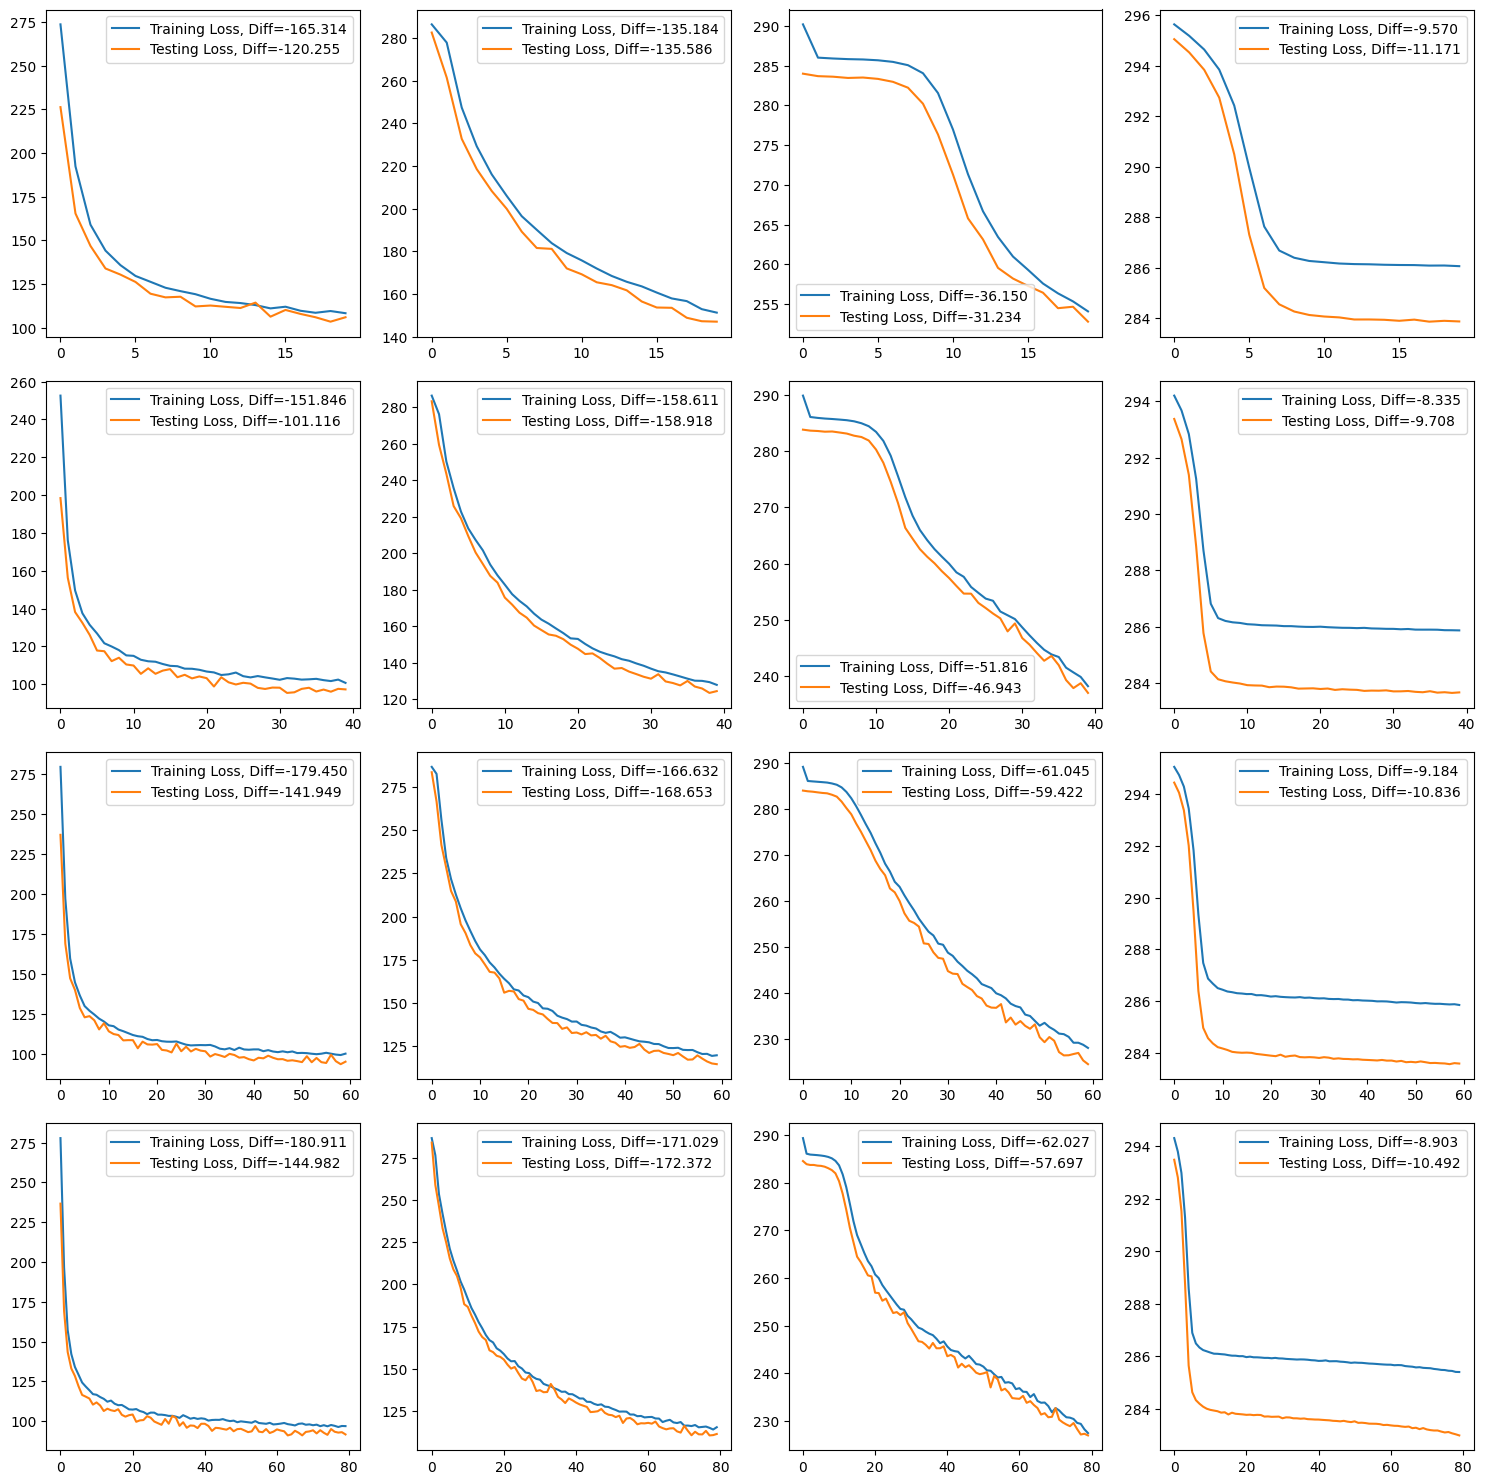

In [49]:
n_rows = 4
n_cols = 4
fig_size = (15, 15)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
plt.tight_layout()

for i, ax in enumerate(axes.flat):
    train_losses, test_losses = loaded_experiments[i]["train_losses"], loaded_experiments[i]["test_losses"]

    train_difference = train_losses[-1]-train_losses[0]
    test_difference = test_losses[-1]-test_losses[0]
    
    ax.plot(train_losses, label=f"Training Loss, Diff={train_difference:.3f}")
    ax.plot(test_losses, label=f"Testing Loss, Diff={test_difference:.3f}")
    # ax.xlabel("Epochs")
    # ax.ylabel("Loss")
    # ax.set_title(f"epoch_num={loaded_experiments[i]["num_epoch"]}, lr={loaded_experiments[i]["lr"]}")
    ax.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title(f"Epoch-Loss")
plt.show()